In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, LSTMAutoEncoder
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in RMS data for tests

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
# exps = ['Test 9']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


In [3]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

for test in exps:
    rms[test]._data = rms[test].data.iloc[50:350, :].reset_index(drop=True)
    rms[test]._data = rms[test].data.apply(remove_dc, axis=0)

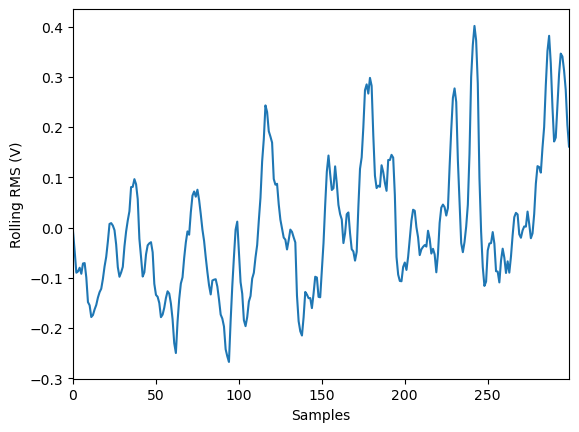

In [4]:
r = rms['Test 9'].data.values
r.shape
plt.plot(r[:, 43])
plt.xlabel('Samples')
plt.ylabel('Rolling RMS (V)')
plt.autoscale(enable=True, axis='x', tight=True)
# plt.plot(r[:, 120])
# plt.plot(r[:, 145])

# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [5]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                           tb=False,
                                           tb_logdir=rms[test].exp_name,
                                           train_slice=(0, 75),
                                        #    random_state=1,
                                           val_frac=0.33,
                                           params={'latent_dim': 4,
                                                   'n_size': [64, 32],
                                                   'epochs': 1000,
                                                   'batch_size': 15,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=60,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 50),
                                  val_frac=0.33,
                                  random_state=2,
                                  params={'n_bottleneck': 9,
                                          'n_size': [42, 32, 16],
                                          'epochs': 1000,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=80,
                                                              mode='min',
                                                              start_from_epoch= 150,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       
        """
        autoe[test] = LSTMAutoEncoder(rms[test],
                                      tb=True,
                                      tb_logdir='LSTMAE_test',
                                      train_slice=(0, 50),
                                      val_frac=0.33,
                                      params={'epochs': 1000,
                                              'batch_size': 40,
                                              'n_size': [64, 32, 32],
                                              'seq_len': 1,
                                              'n_bottleneck': 8,
                                              'loss': 'mse',
                                              'callbacks': [
                                                      tf.keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        patience=80,
                                                        mode='min',
                                                        start_from_epoch= 150,
                                                        ),
                                                 ]
                                      }
                                )
        """

Pre-Processing Data:
	Training Data: slice(0, 50, None)
	Input train shape: (33, 300)
	Input val shape: (17, 300)

AUTOE-Test_5-E-1000-L-[42, 32, 16, 9, 16, 32, 42]-20230706-115557

Pre-Processing Data:
	Training Data: slice(0, 50, None)
	Input train shape: (33, 300)
	Input val shape: (17, 300)

AUTOE-Test_7-E-1000-L-[42, 32, 16, 9, 16, 32, 42]-20230706-115557

Pre-Processing Data:
	Training Data: slice(0, 50, None)
	Input train shape: (33, 300)
	Input val shape: (17, 300)

AUTOE-Test_8-E-1000-L-[42, 32, 16, 9, 16, 32, 42]-20230706-115557

Pre-Processing Data:
	Training Data: slice(0, 50, None)
	Input train shape: (33, 300)
	Input val shape: (17, 300)

AUTOE-Test_9-E-1000-L-[42, 32, 16, 9, 16, 32, 42]-20230706-115557



In [6]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [7]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [8]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [9]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

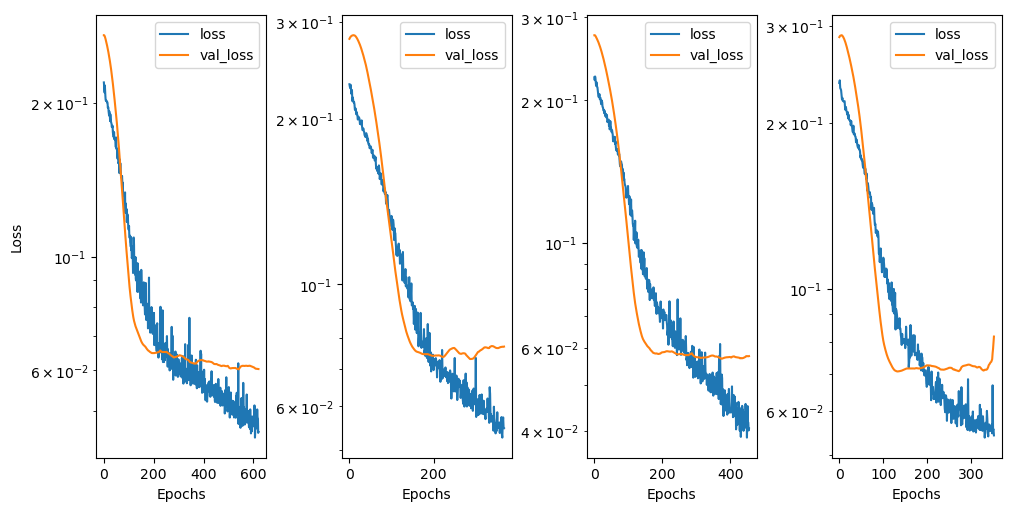

In [10]:
fig, ax = plt.subplots(1, len(exps),
                       figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [11]:
for test in exps:
    autoe[test].scores = None
    autoe[test].pred = None

In [12]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Train Scores:
	MAE: 0.15777
	MSE: 0.04308
	R2: 0.30506

Val Scores:
	MAE: 0.18922
	MSE: 0.06032
	R2: 0.12083

Dataset Scores:
	MAE: 0.30766
	MSE: 0.19760
	R2: 0.05589

 Test 7

Train Scores:
	MAE: 0.18156
	MSE: 0.05465
	R2: 0.10146

Val Scores:
	MAE: 0.21061
	MSE: 0.07313
	R2: 0.05864

Dataset Scores:
	MAE: 0.27593
	MSE: 0.13876
	R2: 0.00645

 Test 8

Train Scores:
	MAE: 0.14903
	MSE: 0.03815
	R2: 0.39104

Val Scores:
	MAE: 0.18372
	MSE: 0.05684
	R2: 0.16750

Dataset Scores:
	MAE: 0.23223
	MSE: 0.19727
	R2: 0.22333

 Test 9

Train Scores:
	MAE: 0.20125
	MSE: 0.06440
	R2: -0.00781

Val Scores:
	MAE: 0.20888
	MSE: 0.07074
	R2: 0.02227

Dataset Scores:
	MAE: 0.31110
	MSE: 0.18893
	R2: 0.00192


## Show histogram of scores across training dataset

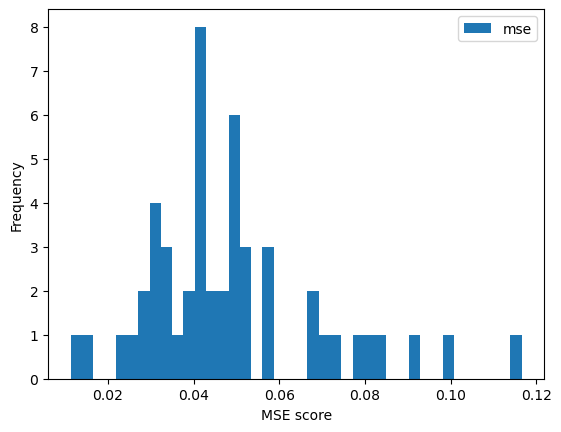

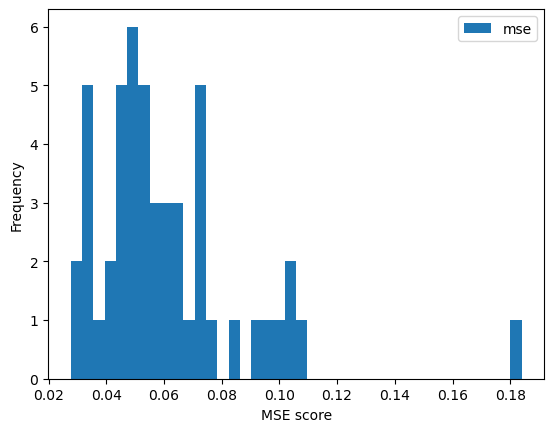

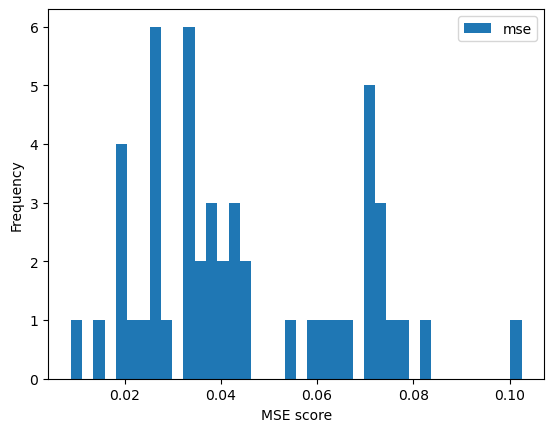

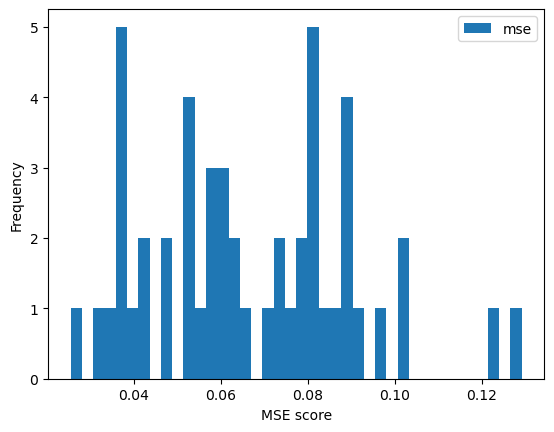

In [13]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

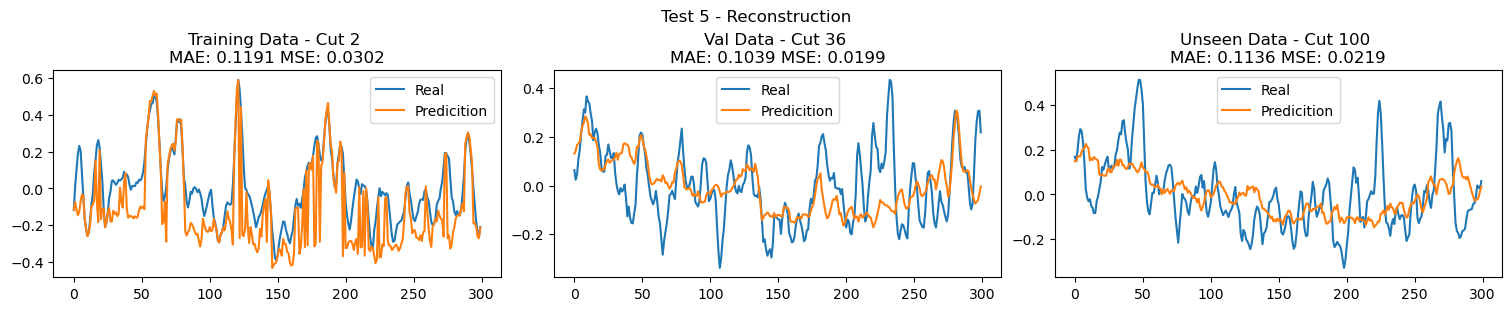

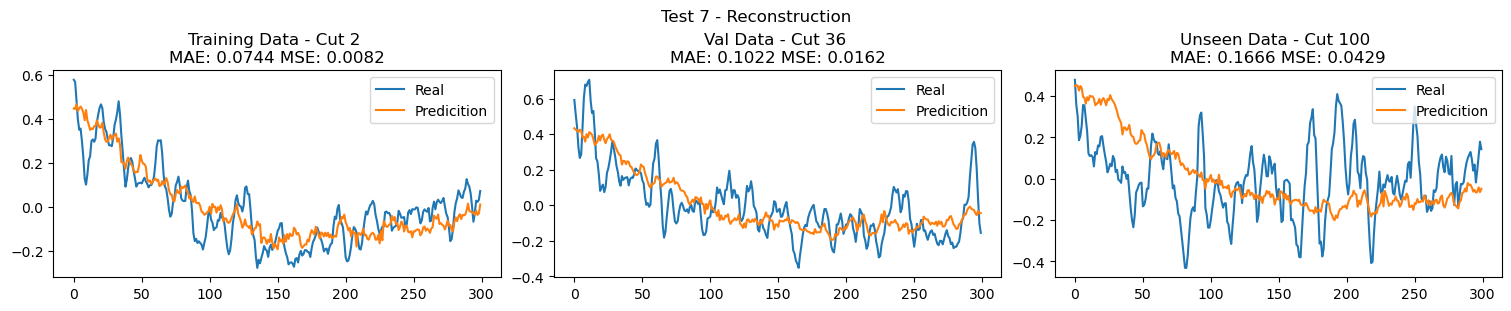

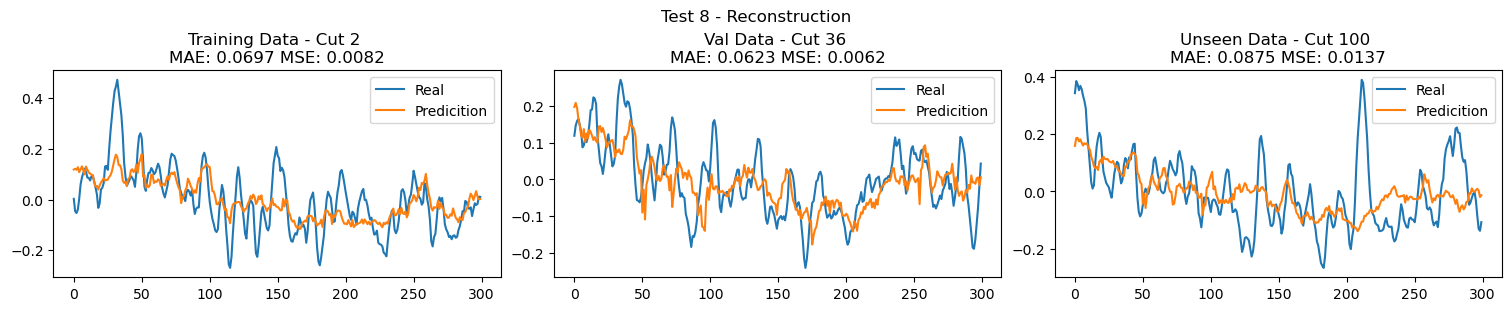

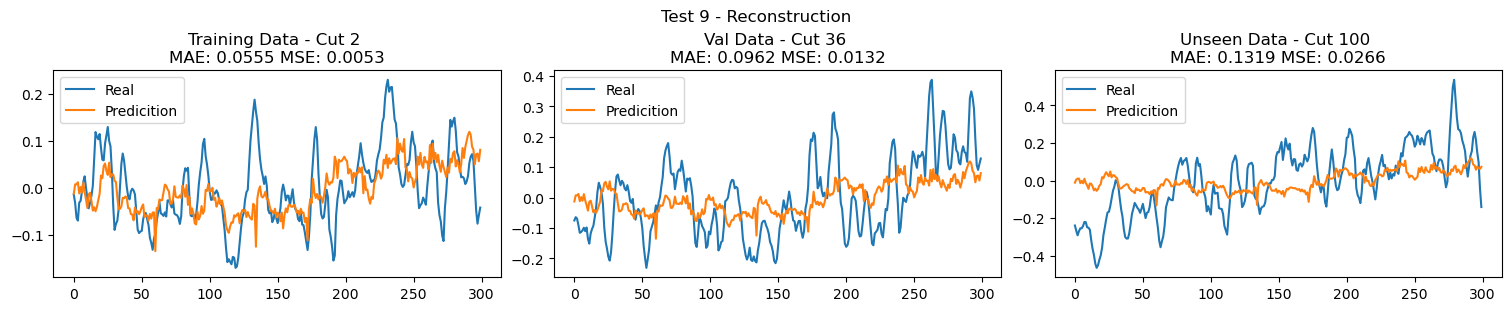

In [14]:
for test in exps:
    fig, ax = plt.subplots(1, 3, figsize=(15,3), constrained_layout=True)
    fig.suptitle(f'{autoe[test].RMS.exp_name} - Reconstruction')
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'Training Data - Cut {autoe[test]._ind_tr[0]} \n{ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'Val Data - Cut {autoe[test]._ind_val[0]} \n{ax[1].get_title()}')

    # Unseen plot
    i = 100
    ax[2] = autoe[test].pred_plot(i, input=(autoe[test].data, autoe[test].pred), plt_ax=ax[2])
    ax[2].set_title(f'Unseen Data - Cut {i} \n{ax[2].get_title()}')

## Thresholds for anomaly detection of each model

In [15]:
for test in exps:
    autoe[test]._thres = None

In [16]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.20086
	MSE cutoff: 0.06506
	R2 cutoff: -0.01345

Cutoffs:
	MAE cutoff: 0.22653
	MSE cutoff: 0.08101
	R2 cutoff: -0.19313

Cutoffs:
	MAE cutoff: 0.19313
	MSE cutoff: 0.05961
	R2 cutoff: 0.12834

Cutoffs:
	MAE cutoff: 0.24045
	MSE cutoff: 0.08723
	R2 cutoff: -0.24240


## Show scores against threshold

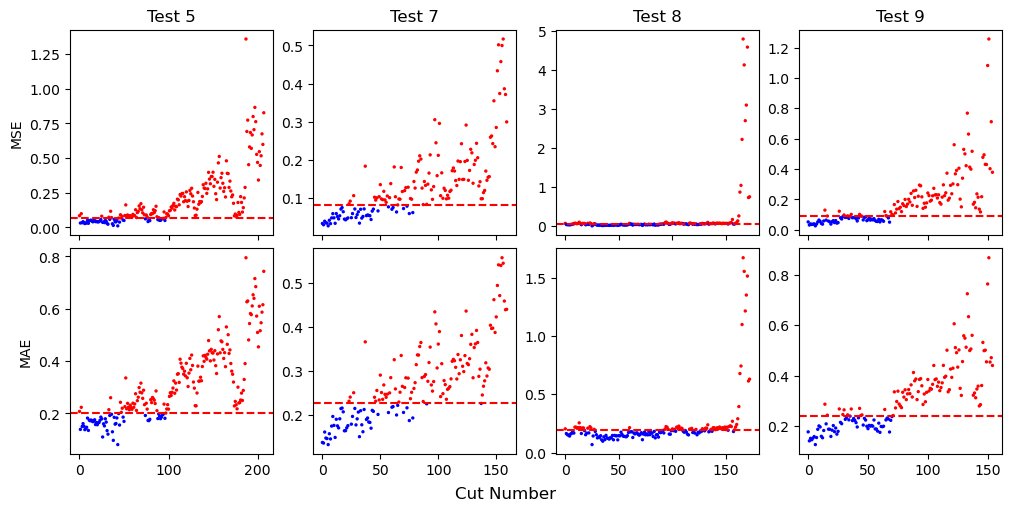

In [17]:
# metrics = ['mse', 'mae', 'r2']
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

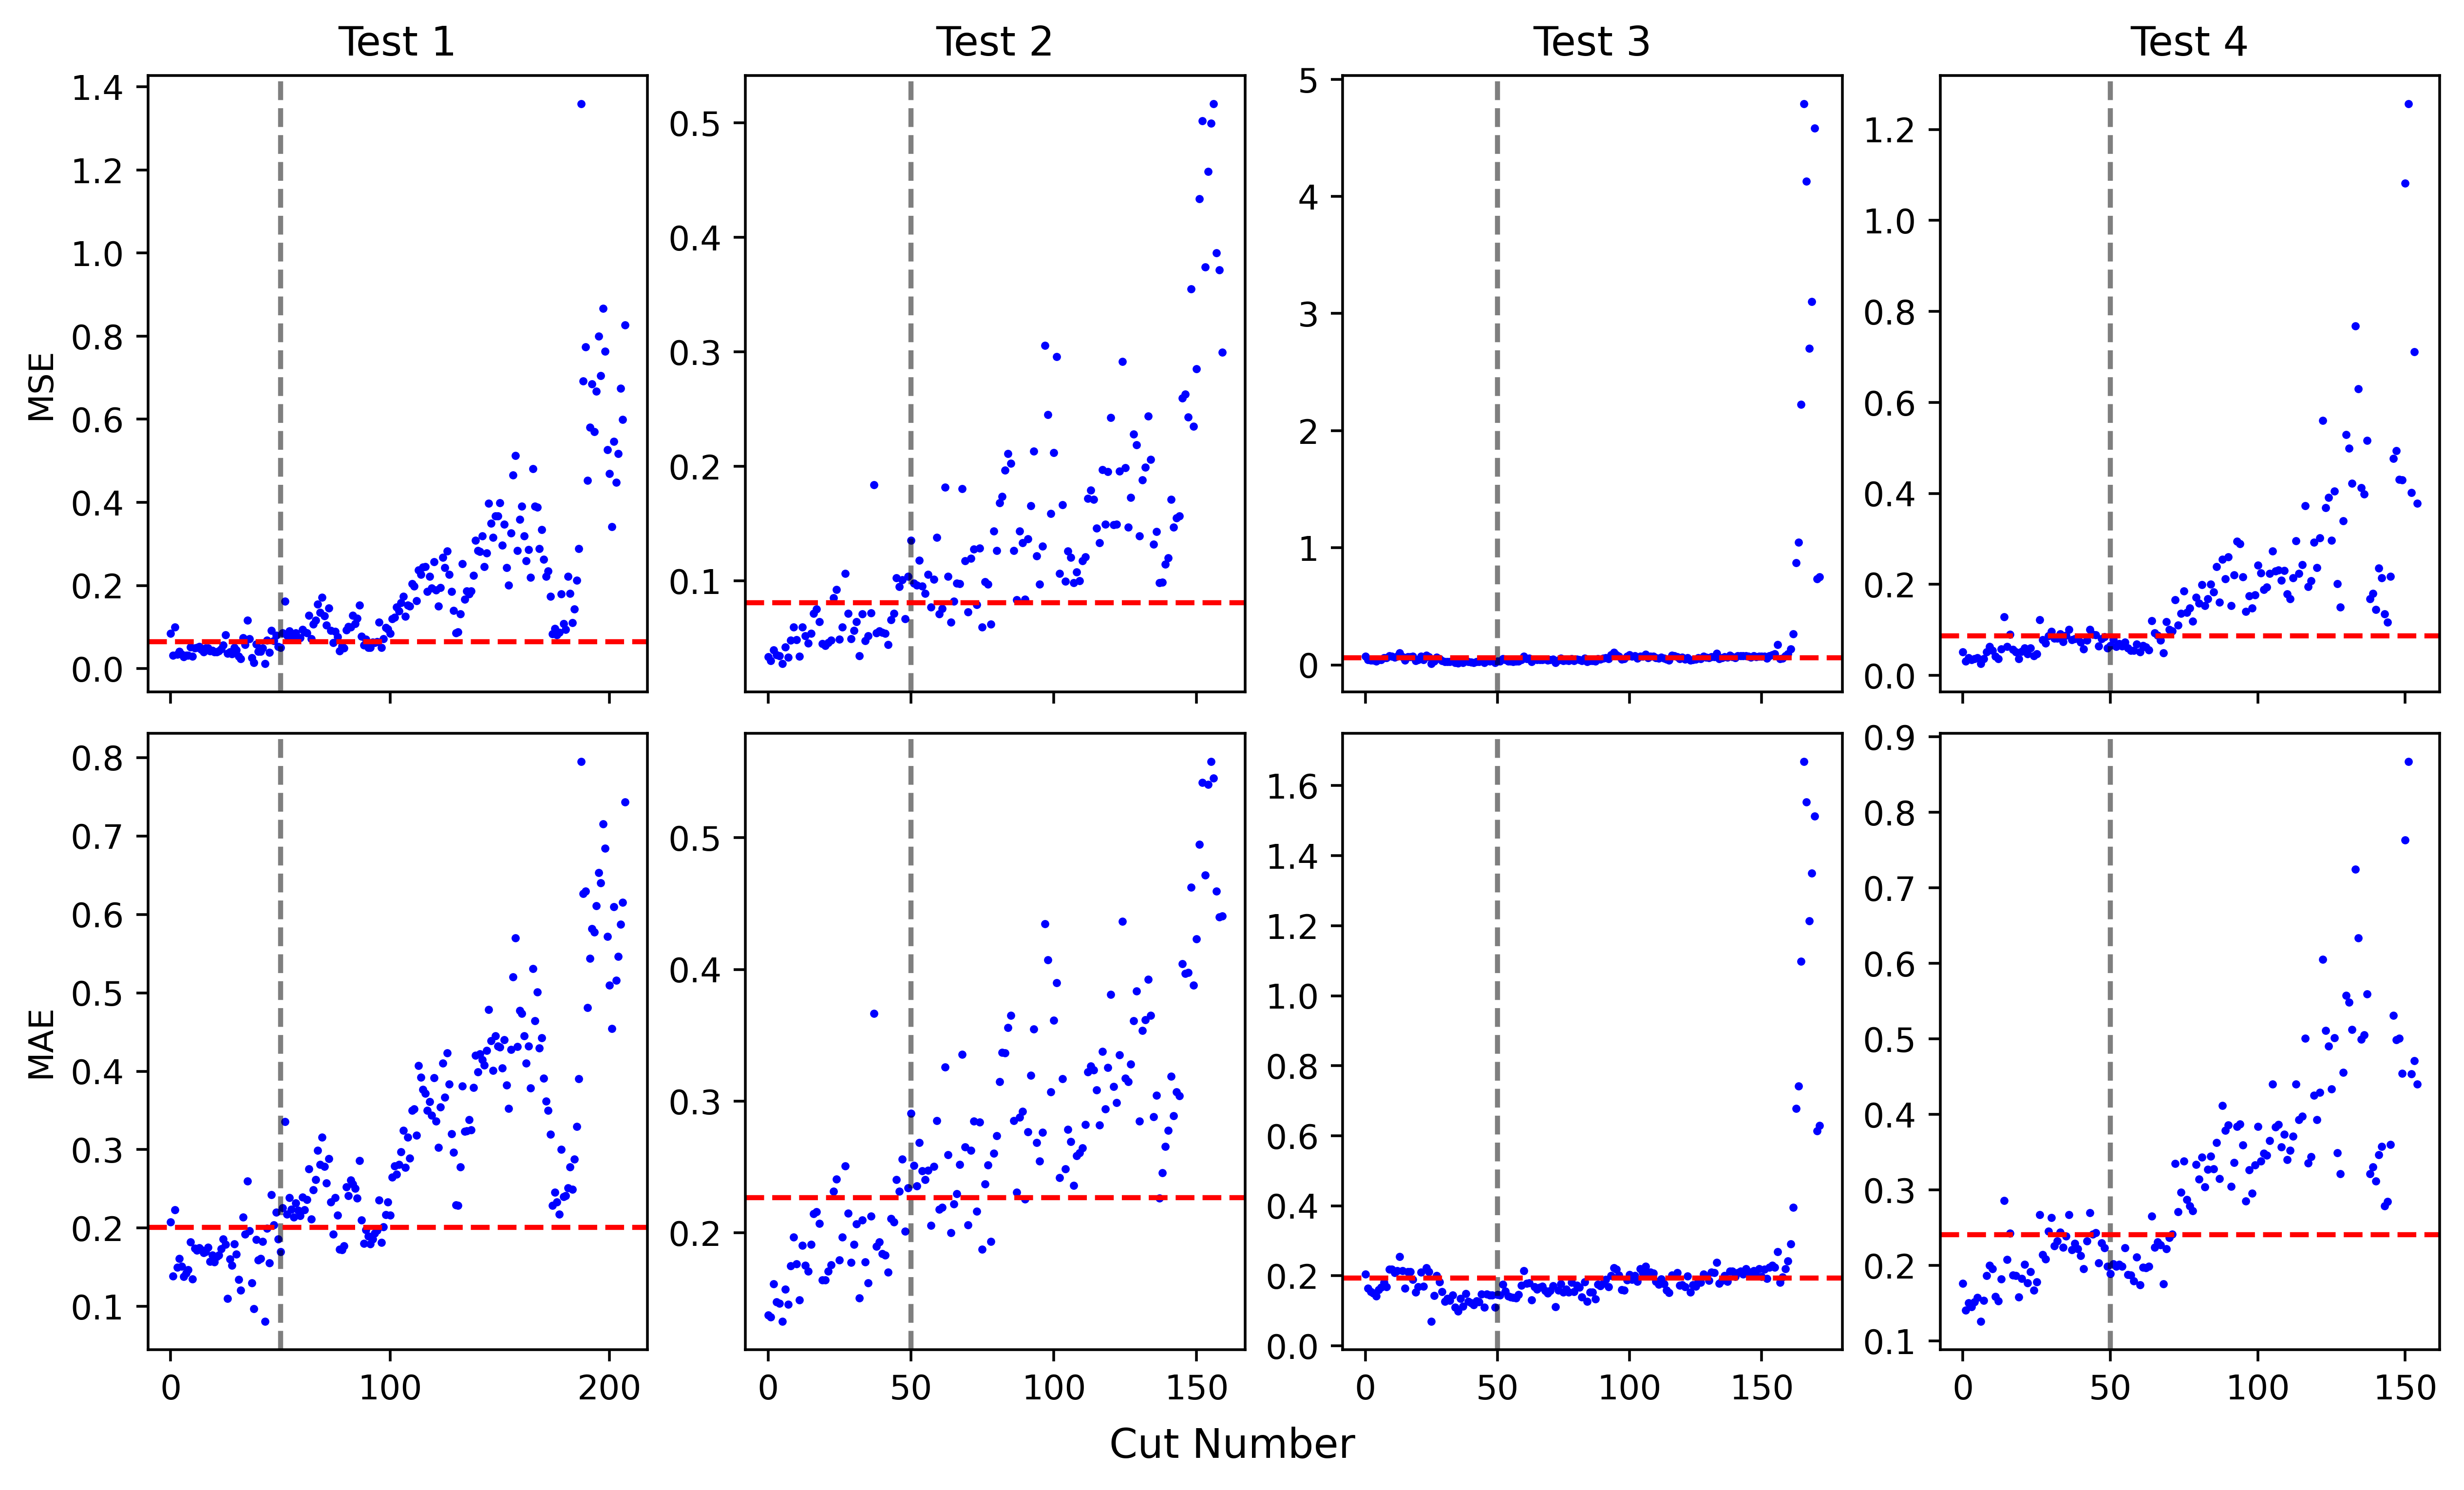

In [37]:
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                       sharex='col',
                       dpi=500
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        # _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])
        score = autoe[test].scores[met]
        axes[(i + (j * len(exps)))].scatter(x=range(len(score)),
                                            y=score,
                                            s=2,
                                            label=met,
                                            c='b'
                                            )

        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        axes[(i + (j * len(exps)))].axhline(autoe[test].thres[met], color='r', linestyle='--')

        axes[(i)].set_title(f'Test {i+ 1}')
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [19]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  208.000000  208.000000  208.000000
mean     0.307664    0.197602    0.055890
std      0.141982    0.197387    0.193778
min      0.080865    0.011318   -0.663815
25%      0.195892    0.066549   -0.036075
50%      0.266752    0.126473    0.039560
75%      0.393860    0.257370    0.110317
max      0.795024    1.359347    0.832715

 Test 7
              mae         mse          r2
count  160.000000  160.000000  160.000000
mean     0.275926    0.138762    0.006446
std      0.090745    0.097607    0.224992
min      0.132643    0.027651   -2.083053
25%      0.207961    0.071123   -0.065978
50%      0.261720    0.116105    0.035230
75%      0.324049    0.173089    0.110425
max      0.557928    0.516865    0.432318

 Test 8
              mae         mse          r2
count  173.000000  173.000000  173.000000
mean     0.232231    0.197272    0.223335
std      0.239737    0.680872    0.155070
min      0.069147    0.008806   -0.195198
25%    

## autoe models latent space

In [20]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

/tmp/ipykernel_6520/789214694.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


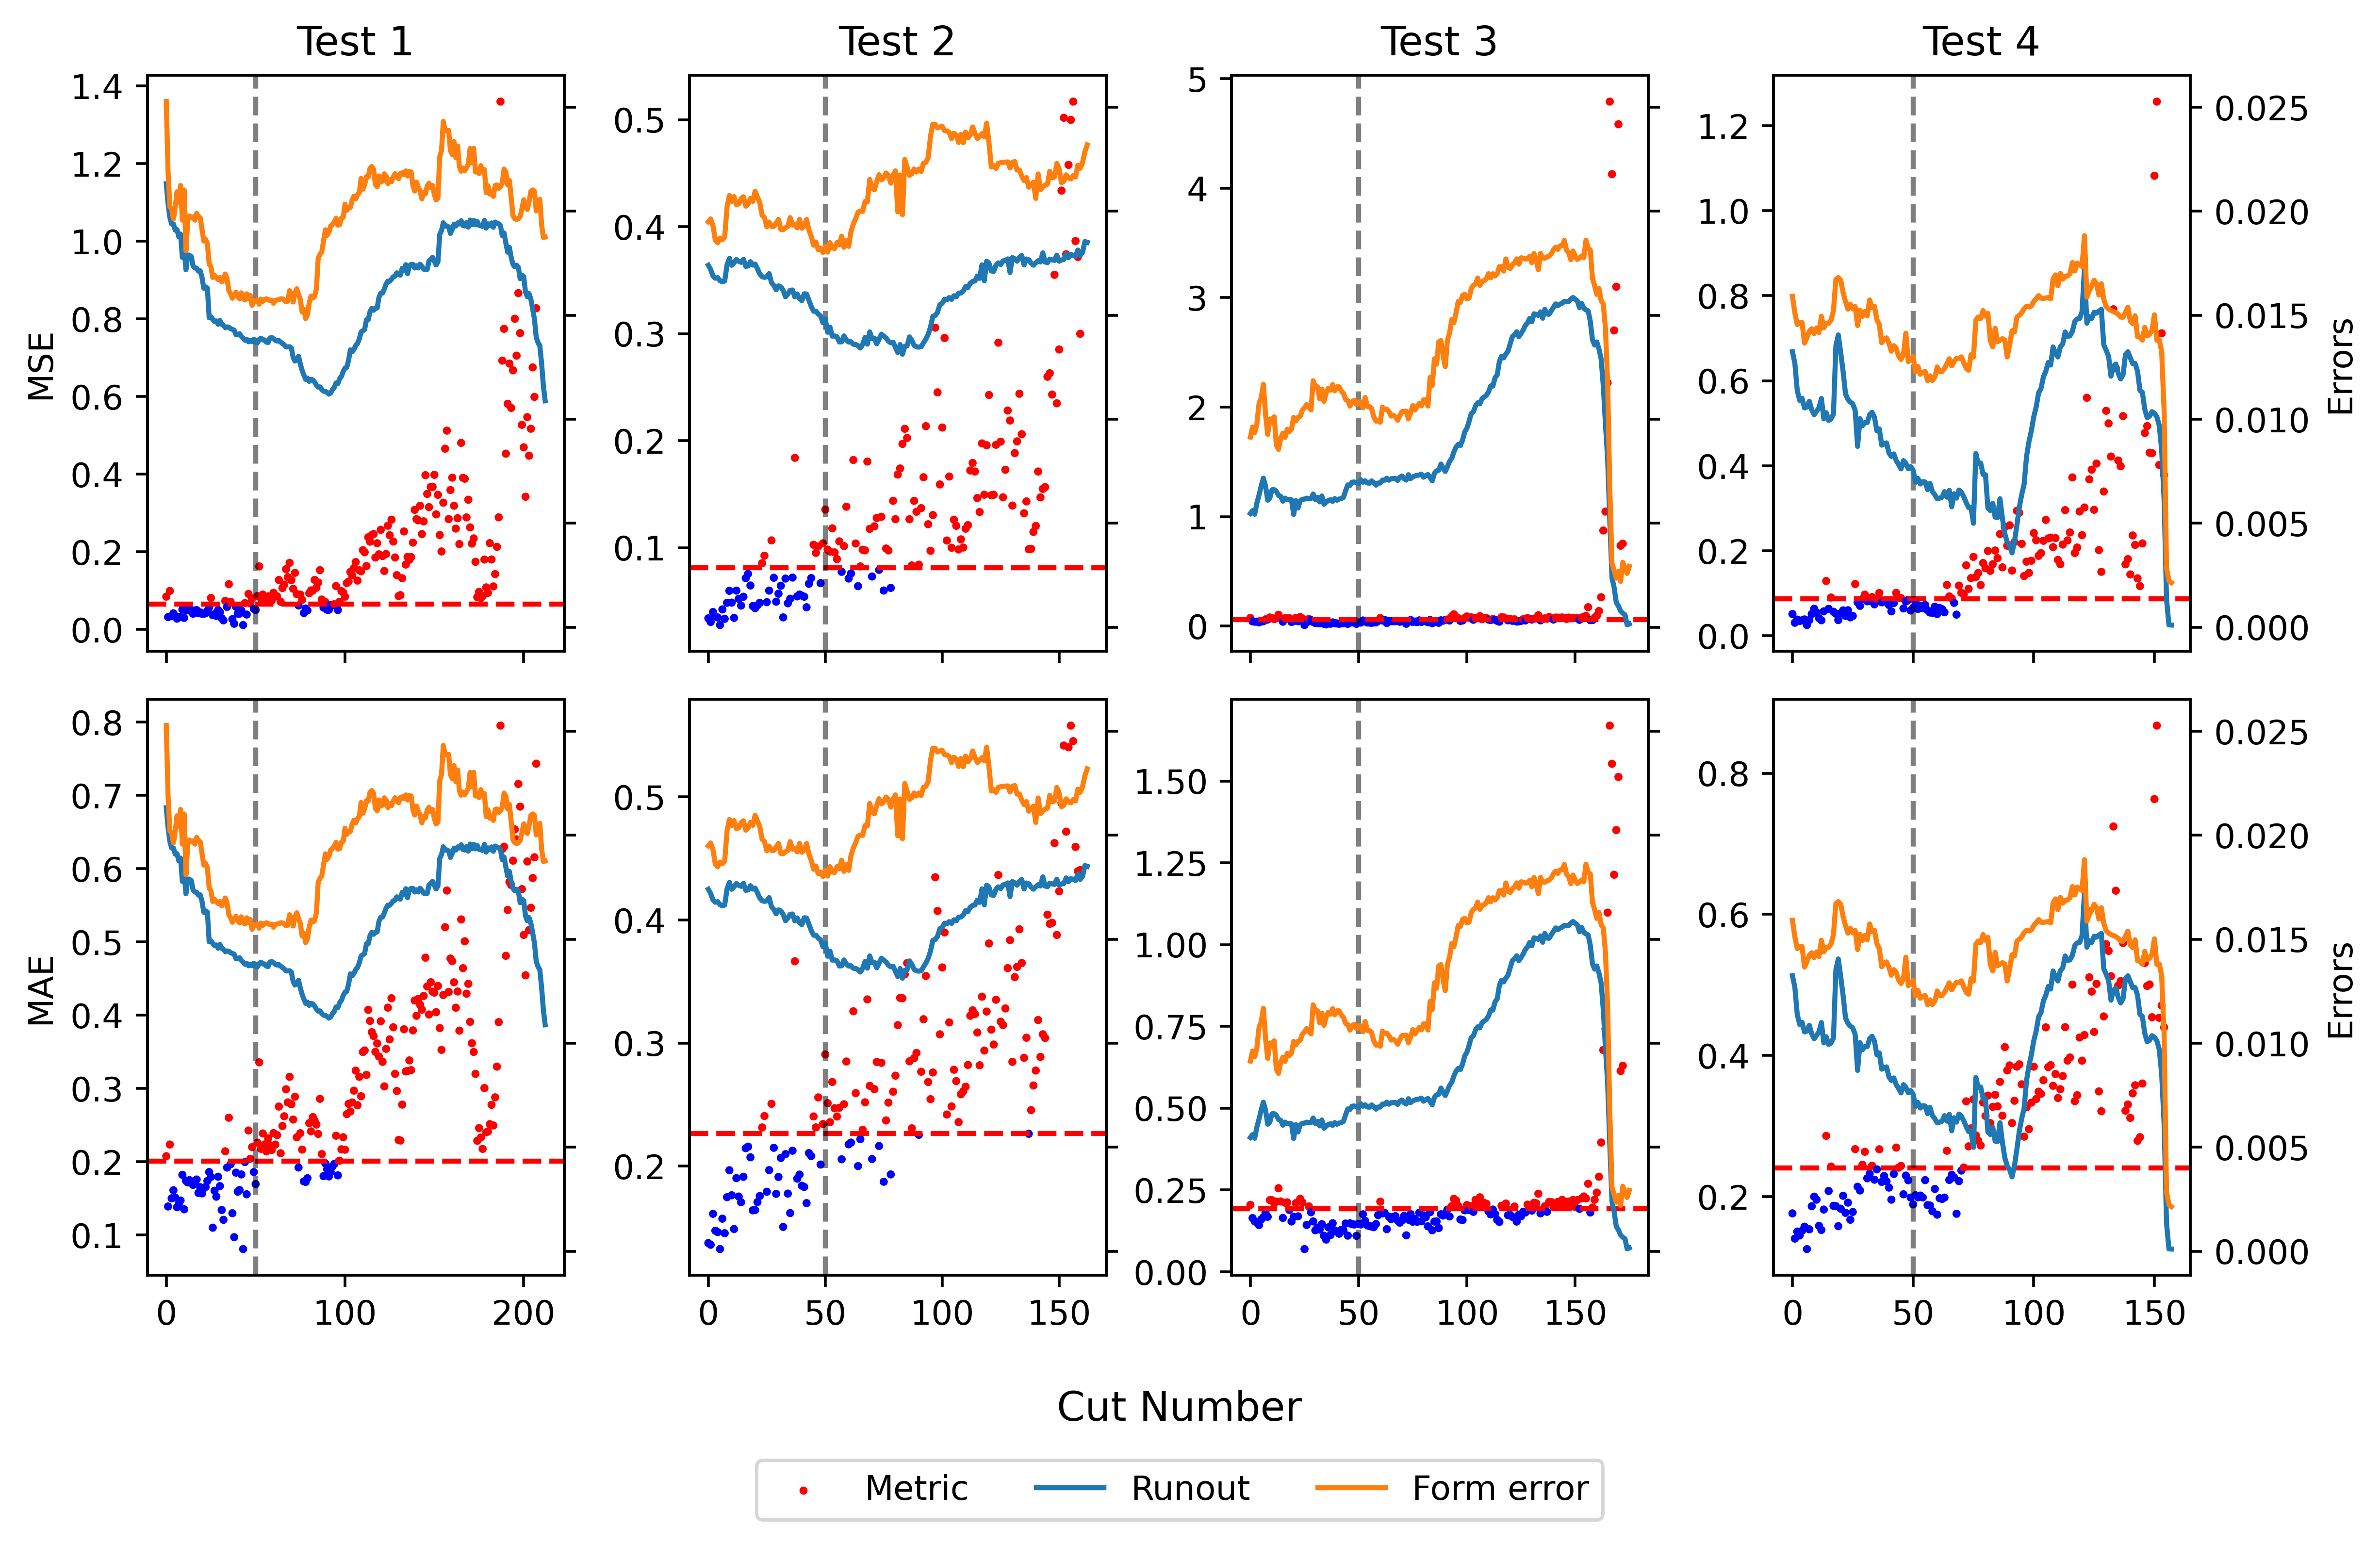

In [36]:
metric = ['mse', 'mae']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(f'Test {i + 1}')
    # axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

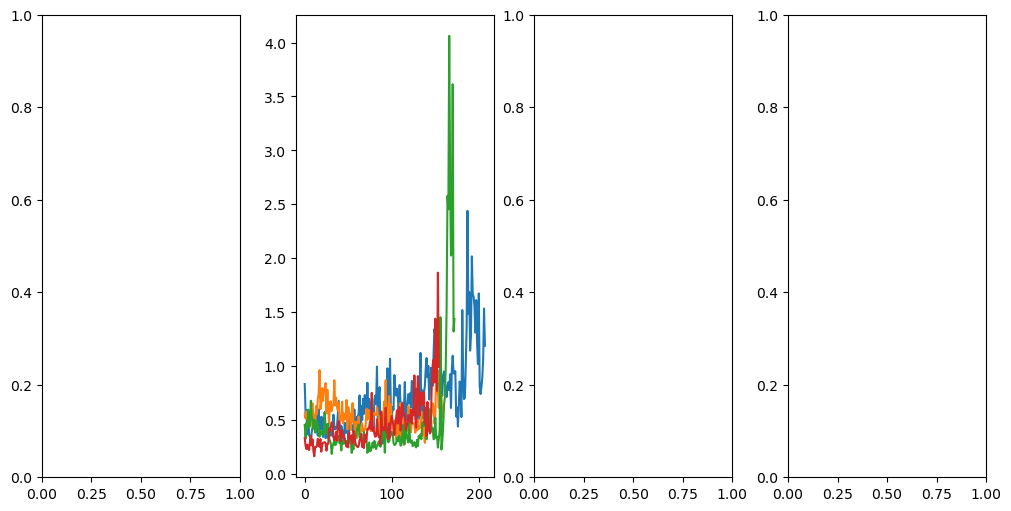

In [22]:
fig, ax = plt.subplots(1, len(exps), figsize=(10,5), constrained_layout=True)
ax = ax.ravel()

for i, test in enumerate(exps):
    amp = np.max(rms[test].data, axis=0)
    ax[1].plot(range(len(amp)), amp)

0.011318162848903981
0.09245996404117712
0.0824353579659009
0.1219271784119343


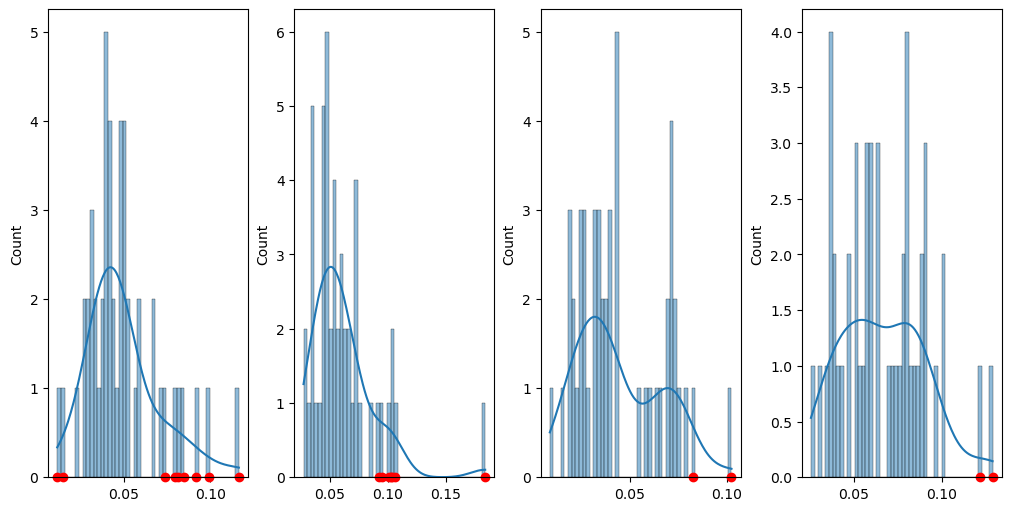

In [23]:
import seaborn as sns

fig, ax = plt.subplots(1, len(exps), figsize=(10,5), constrained_layout=True)
ax = ax.ravel()

for i, test in enumerate(exps):
    a = autoe[test]
    sc = a.scores['mse'][a._train_slice]

    def mad_based_outlier(points, thresh=2):
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

    outliers = sc[mad_based_outlier(sc)]
    print(np.min(outliers))

    sns.histplot(sc, ax=ax[i], kde=True, log_scale=False, bins=50)
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

1/1 [==============================] - 0s 17ms/step


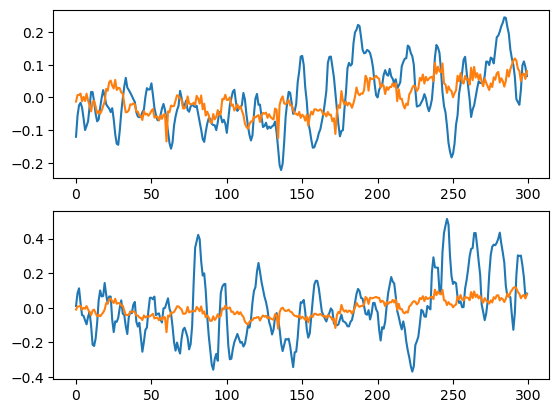

In [24]:
a = autoe['Test 9']
r_50 = r[:, 50]
r_120 = r[:, 145]

p_50 = a.scaler.inverse_transform(a.model.predict(a.scaler.transform(r_50.reshape(1, -1))))
p_120= a.scaler.inverse_transform(a.model.predict(a.scaler.transform(r_120.reshape(1, -1))))

fig, ax = plt.subplots(2, 1)
ax[0].plot(r_50.T)
ax[0].plot(p_50.T)

ax[1].plot(r_120.T)
ax[1].plot(p_120.T)

# LSTM with Encoded Input

## Encode Inputs

In [25]:
encoders = {}
for test in exps:
    ae = autoe[test].model.model_
    encoders[test] = Model(inputs=ae.get_layer('Encoder').input, outputs=ae.get_layer('Encoder').output)

In [26]:
encoded_inputs = {}
for test in exps:
    inp = rms[test].data.values
    inp = autoe[test].scaler.transform(inp.T)
    encoded_inputs[test] = encoders[test].predict(inp, verbose=0)

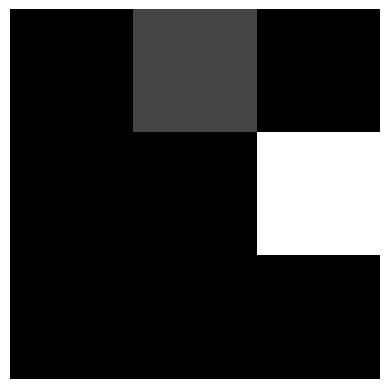

In [27]:
e = encoded_inputs['Test 9']
e_50 = e[43, :]
e_50 = e_50.reshape(-1, 3)
plt.imshow(e_50, cmap='gray')
plt.axis('off');

Text(0.5, 1.0, '')

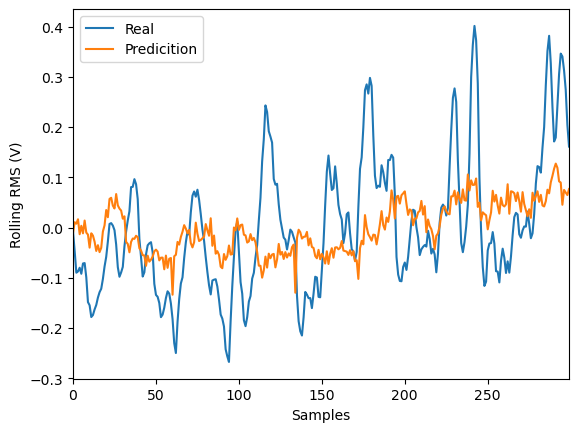

In [28]:
i = 43
autoe['Test 9'].pred_plot(i)
plt.xlabel('Samples')
plt.ylabel('Rolling RMS (V)')
# plt.ylim(0,)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title(None)

In [29]:
TARGET = 'Runout'

encoded_main_dfs = {}
for test in exps:
    exp = resources.load(test)
    target = exp.features[TARGET]
    if exp.test_info.testno == 5:
        target = target.drop([23, 24], axis=0)
    target = target.drop([0, 1, 2], axis=0).values
    inputs = np.concatenate([encoded_inputs[test], target.reshape(-1, 1)], axis=1)
    encoded_main_dfs[test] = pd.DataFrame(inputs, columns=['L1', 'L2', 'Target'])
    print(encoded_main_dfs[test].shape)

ValueError: Shape of passed values is (208, 10), indices imply (208, 3)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# for test in exps:
#     scaler = MinMaxScaler()
#     y = scaler.fit_transform(encoded_main_dfs[test]['Target'].values.reshape(-1, 1))
#     encoded_main_dfs[test]['Target'] = y

In [ ]:
joined_df = pd.concat(encoded_main_dfs.values())
joined_df.reset_index(drop=True, inplace=True)

In [ ]:
joined_df.plot(y='Target', figsize=(15, 5))

## LSTM Setup

In [ ]:
main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[0]]
# ml = resources.LSTM_Model(feature_df=joined_df, # .iloc[:600],
                          target='Target',
                          tb=True,
                          tb_logdir='encoded_input_form_error',
                          params={'epochs': 2000,
                                  'seq_len': 40,
                                  'no_nodes': 64, #180,
                                  'batch_size': 50,
                                  'no_layers': 1, #5,
                                  'no_dense': 0,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=150,
                                                              mode='min',
                                                              start_from_epoch= 100,
                                                  ),]
                                  },
                          # random_state=10,
                          # shuffle=False,
)

In [ ]:
ml.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [ ]:
ml.fit(validation_split=0.33, verbose=0)

In [ ]:
ml.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)
# ml.model.model_.load_weights('/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard/LSTM/autoe_encoder_test/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521.h5')

In [ ]:
fig, ax = ml.loss_plot()
ax.set_yscale('log')

In [ ]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicted')
    return ax

fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml.val_data[1], ml.model.predict(ml.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml.train_data[1], ml.model.predict(ml.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [ ]:
print('TRAINING DATA')
_ = ml.score(X=ml.train_data[0],
              y=ml.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml.score(plot_fig=False)

In [ ]:
all_x=joined_df.iloc[:, :-1]
all_y=joined_df.iloc[:, -1] 

all_x= ml.scaler.transform(all_x)

all_data = np.column_stack([all_x, all_y])
all_data = ml.sequence_data(all_data)

# all_data = []
# for x, y in zip(all_x, all_y):
    # all_data.append([list(x), y])

all_data = pd.DataFrame(all_data, columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()
ax.set_xlabel('Cut No.')
ax.set_ylabel(TARGET);
ml.score(X=all_data[0], y=all_data[1], plot_fig=False);

## Transfer Learning

In [ ]:
# tr_split = 100

# main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[1]]
# ml_2 = resources.LSTM_Model(feature_df=main_df.iloc[:tr_split],
#                           target='Target',
#                           tb=True,
#                           tb_logdir='encoded_input',
#                           params={'seq_len': 50,
#                                   'epochs': 2000,
#                                   'no_nodes': 180,
#                                   'batch_size': 50,
#                                   'no_layers': 5,
#                                   'no_dense': 2,
#                                   'dropout': 0.1,
#                                   'loss': 'mse',
#                                   'callbacks': [tf.keras.callbacks.EarlyStopping(
#                                                               monitor='val_loss',
#                                                               patience=150,
#                                                               mode='min',
#                                                               start_from_epoch= 100,
#                                                   ),]
#                                   },
#                           # random_state=1,
#                         #   shuffle=False,
# )

In [ ]:
ml_2.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [ ]:
ml_2.model.initialize(X=ml_2.train_data[0], y=ml_2.train_data[1]);

In [ ]:
ml_2.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)

In [ ]:
ml_2.fit(validation_split=0.1, verbose=0)

In [ ]:
ml_2.model.model_.load_weights(
    ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
)

In [ ]:
fig, ax = ml_2.loss_plot()
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [ ]:
print('TRAINING DATA')
_ = ml_2.score(X=ml_2.train_data[0],
              y=ml_2.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml_2.score(plot_fig=False)

In [ ]:
rest_X = main_df.iloc[tr_split-30:, :-1]
rest_Y = main_df.iloc[tr_split-30:, -1] 

rest_X = ml_2.scaler.transform(rest_X)
rest_data = np.column_stack([rest_X, rest_Y])

rest_data = ml_2.sequence_data(rest_data)
rest_data = pd.DataFrame(rest_data, columns=['features', 'target'])

rest_X = []
rest_Y = []
for X, y in rest_data.values:
    rest_X.append(X)
    rest_Y.append(y)
rest_X = np.array(rest_X)
rest_Y = np.array(rest_Y)
rest_data = [rest_X, rest_Y]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[1])
ax[2] = pred_real_plot(rest_data[1], ml_2.model.predict(rest_data[0], verbose=0), ax[2])
fig.tight_layout()
ml_2.score(X=rest_data[0], y=rest_data[1], plot_fig=False);


In [ ]:
all_x= main_df.iloc[:, :-1]
all_y= main_df.iloc[:, -1] 

all_x= ml_2.scaler.transform(all_x)
all_data = np.column_stack([all_x, all_y])

all_data = ml_2.sequence_data(all_data)
all_data = pd.DataFrame(all_data , columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml_2.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()